In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df = pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

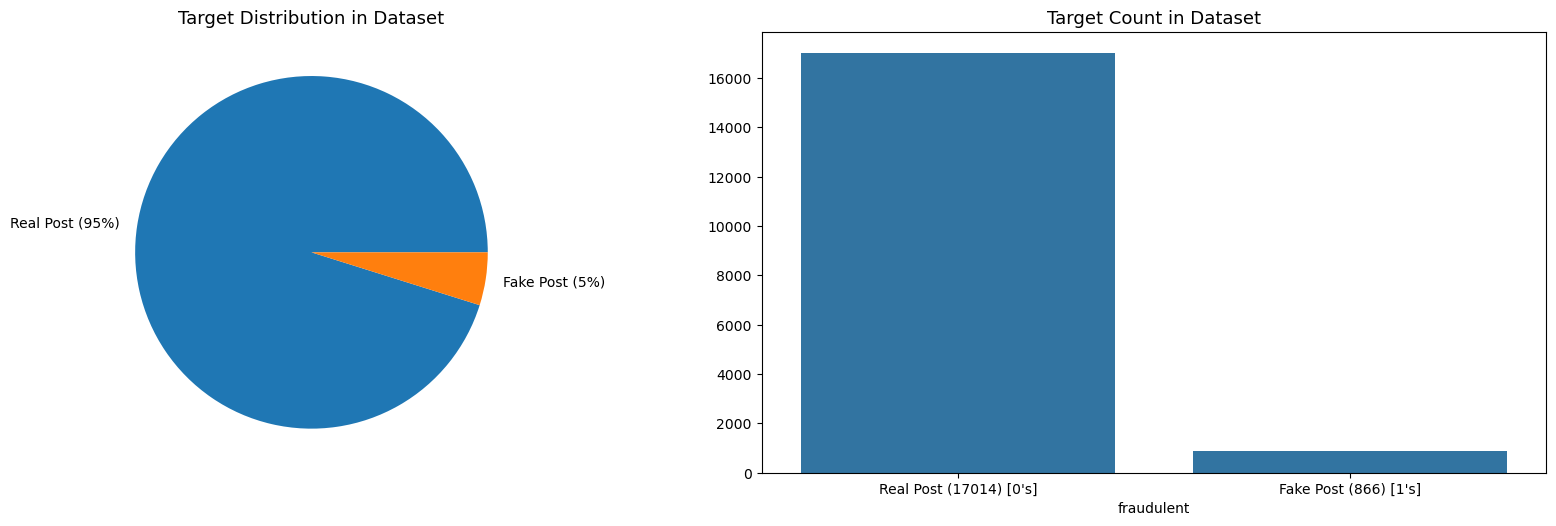

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

# Pie chart
df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])

# Bar chart
temp = df["fraudulent"].value_counts()
sns.barplot(x=temp.index, y=temp.values, ax=axes[1])

# Setting labels
axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticks([0, 1])  # Explicitly set ticks
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

# Titles
axes[0].set_title('Target Distribution in Dataset', fontsize=13)
axes[1].set_title('Target Count in Dataset', fontsize=13)

plt.show()

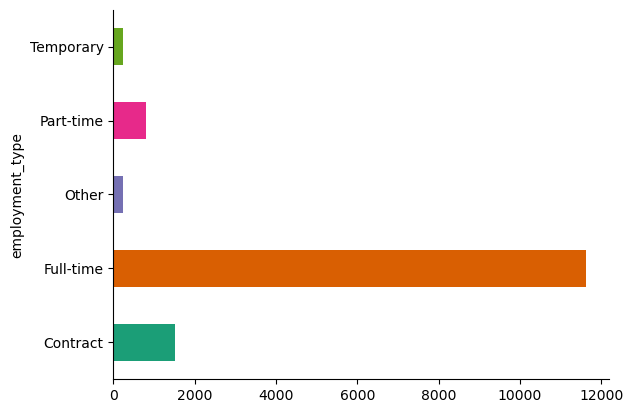

In [9]:
df.groupby('employment_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

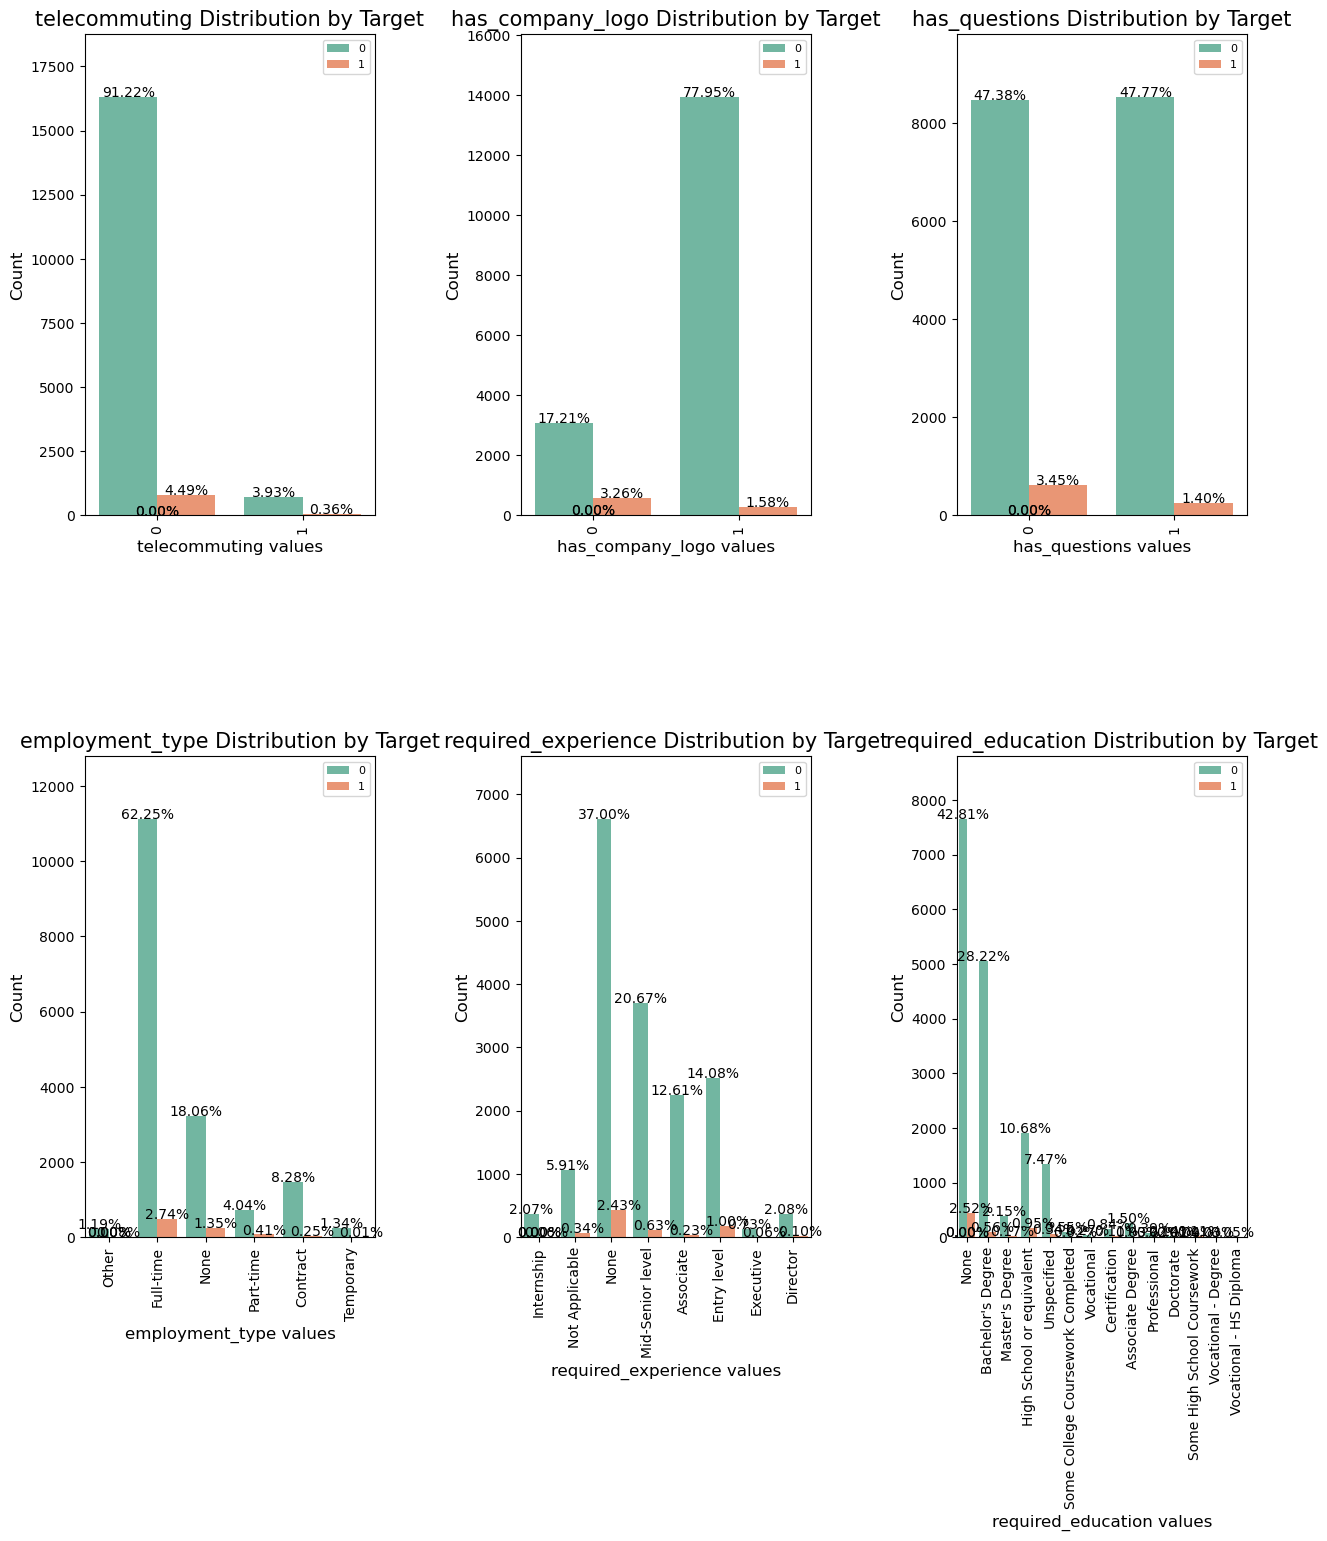

In [10]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education"]
# visualizing categorical variables by target
import matplotlib.gridspec as gridspec  # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5)  # The grid of charts
plt.figure(figsize=(15, 25))  # size of figure

# Loop to create subplots for each column
for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n])  # feeding the figure of grid
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12)  # y-axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15)  # title label
    ax.set_xlabel(f'{col} values', fontsize=12)  # x-axis label

    # Adjust tick label font sizes
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.tick_params(axis='y', labelsize=10)
    plt.legend(fontsize=8)
    
    # Adding percentages above bars
    total = len(cat_df)
    sizes = []  # Get highest values in y
    for p in ax.patches:  # loop through all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}%'.format(height / total * 100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15)  # set y limit based on highest heights

plt.show()

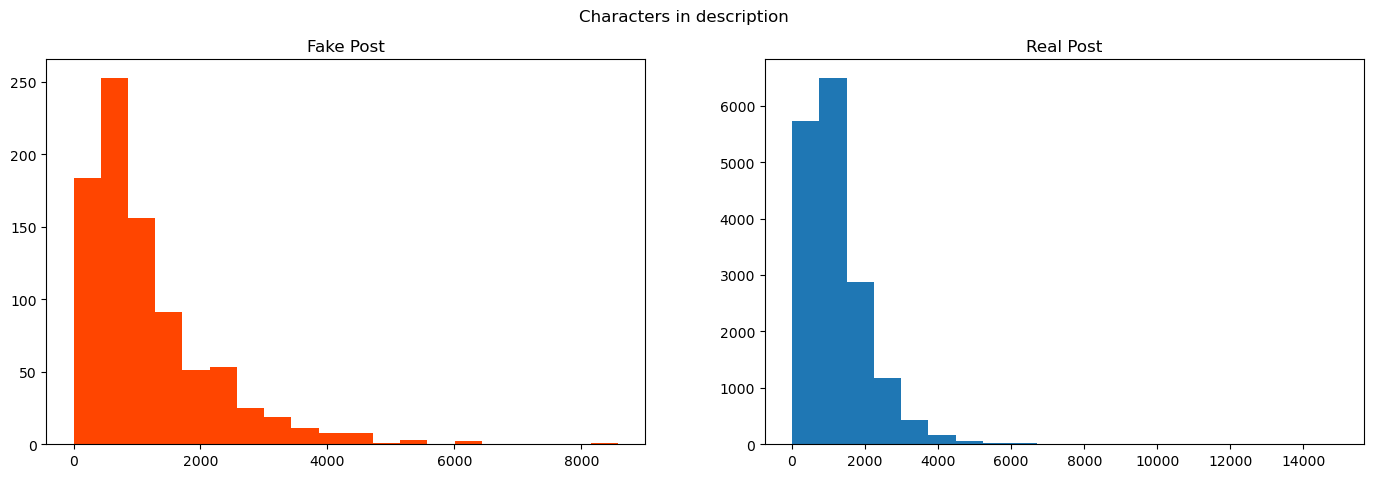

In [11]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

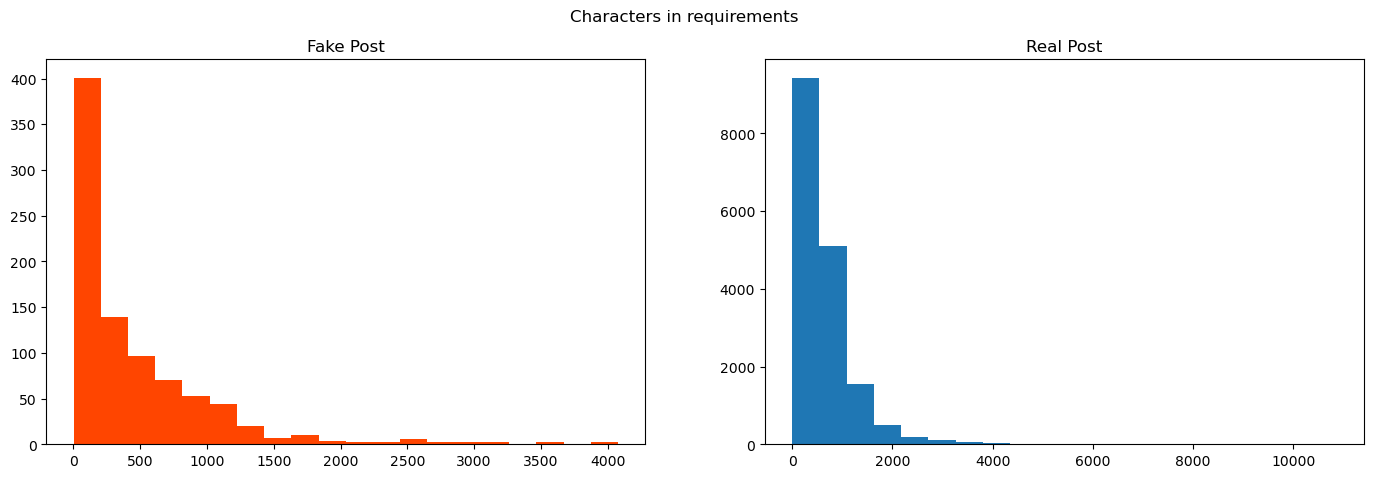

In [12]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

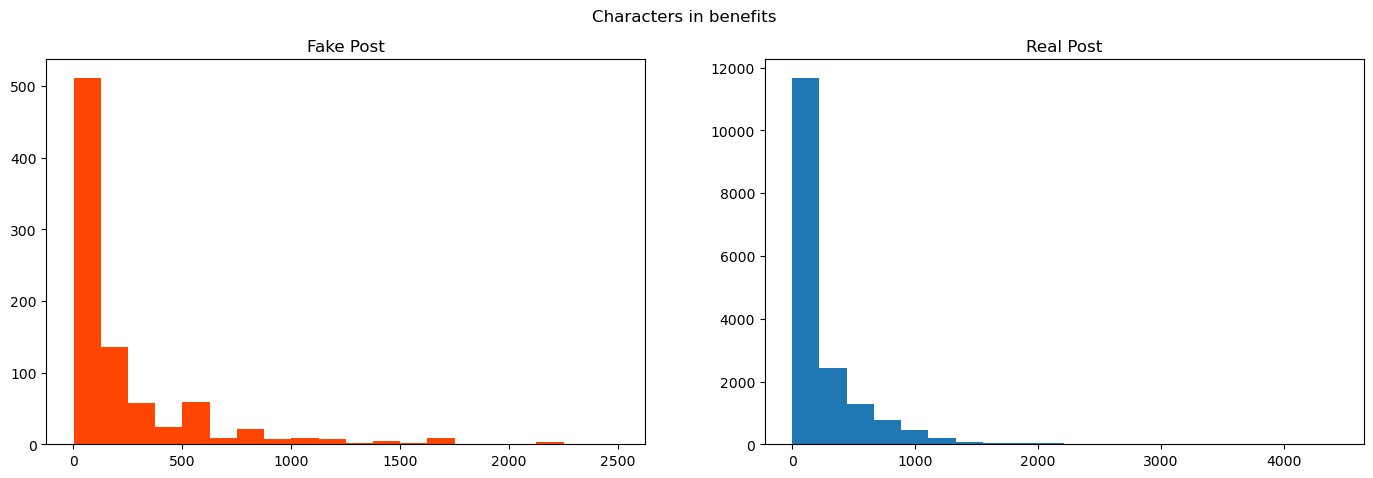

In [13]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=text_df[text_df["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=text_df[text_df["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

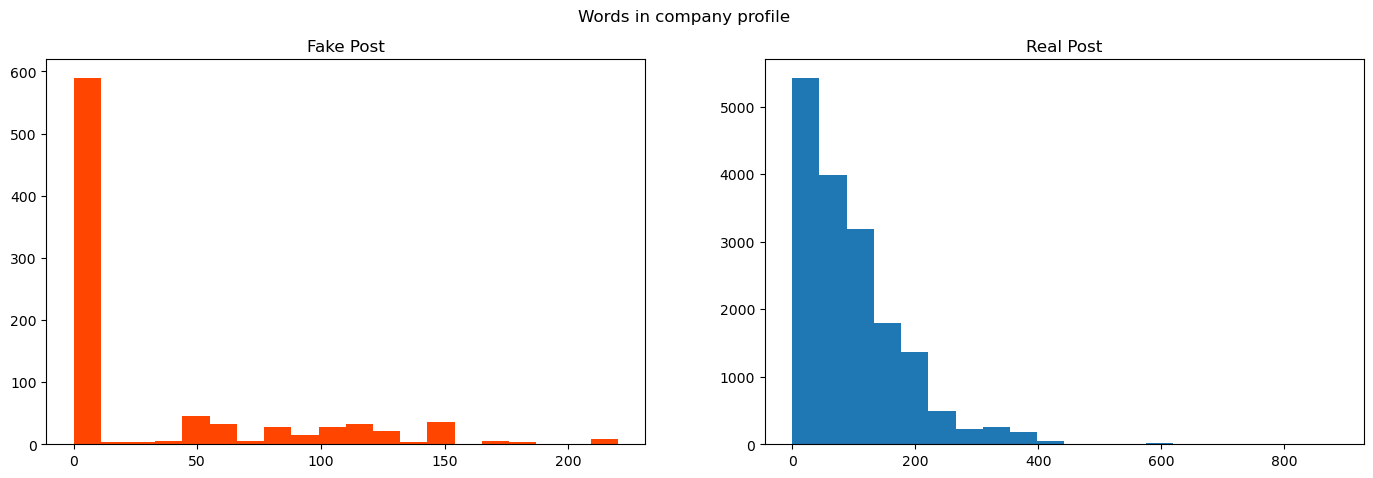

In [14]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

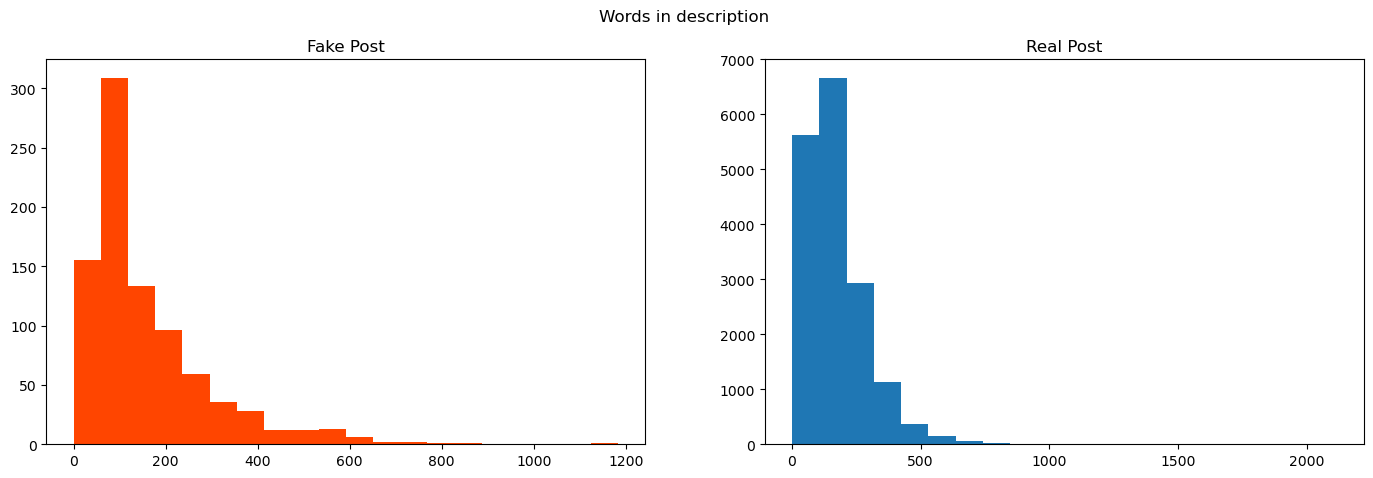

In [15]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in description')
plt.show()

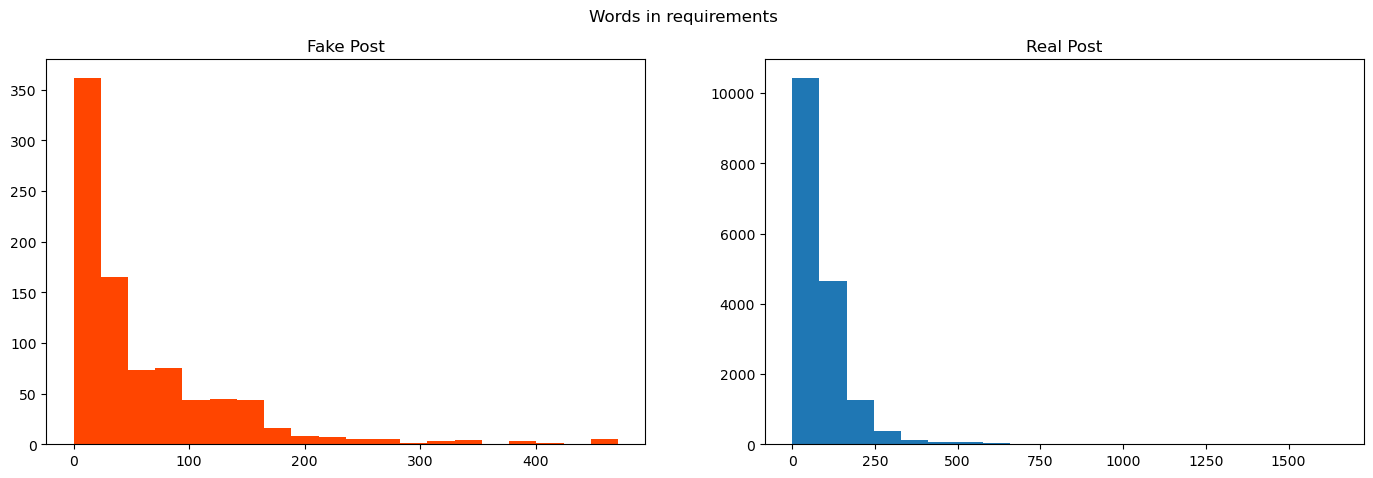

In [16]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in requirements')
plt.show()

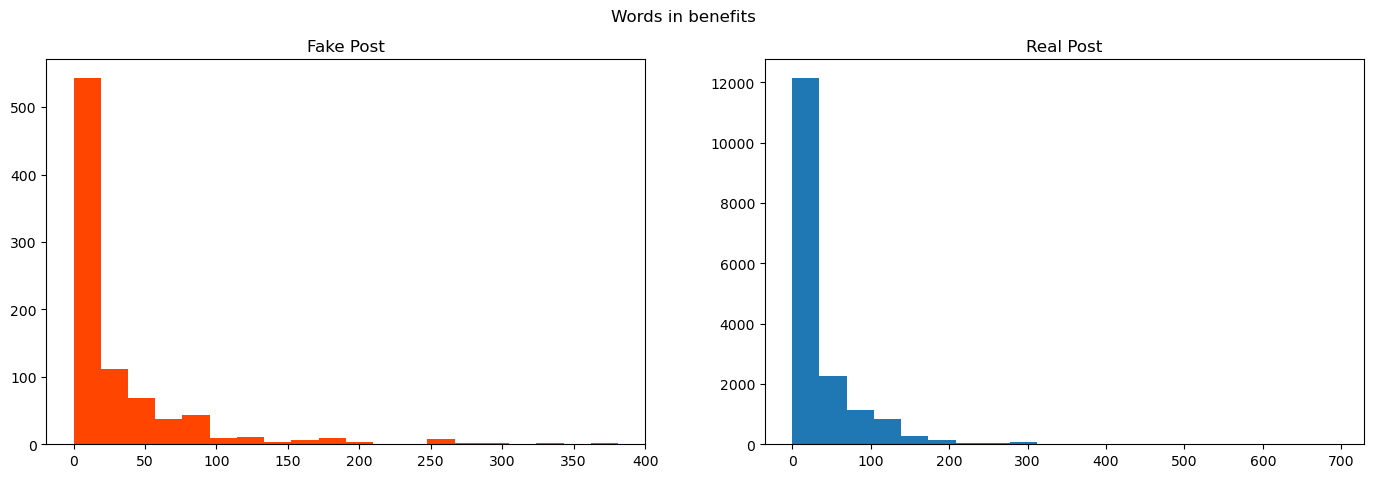

In [17]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='orangered')
ax1.set_title('Fake Post')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Words in benefits')
plt.show()

In [18]:
"""Concate the text data for preprocessing and modeling"""
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


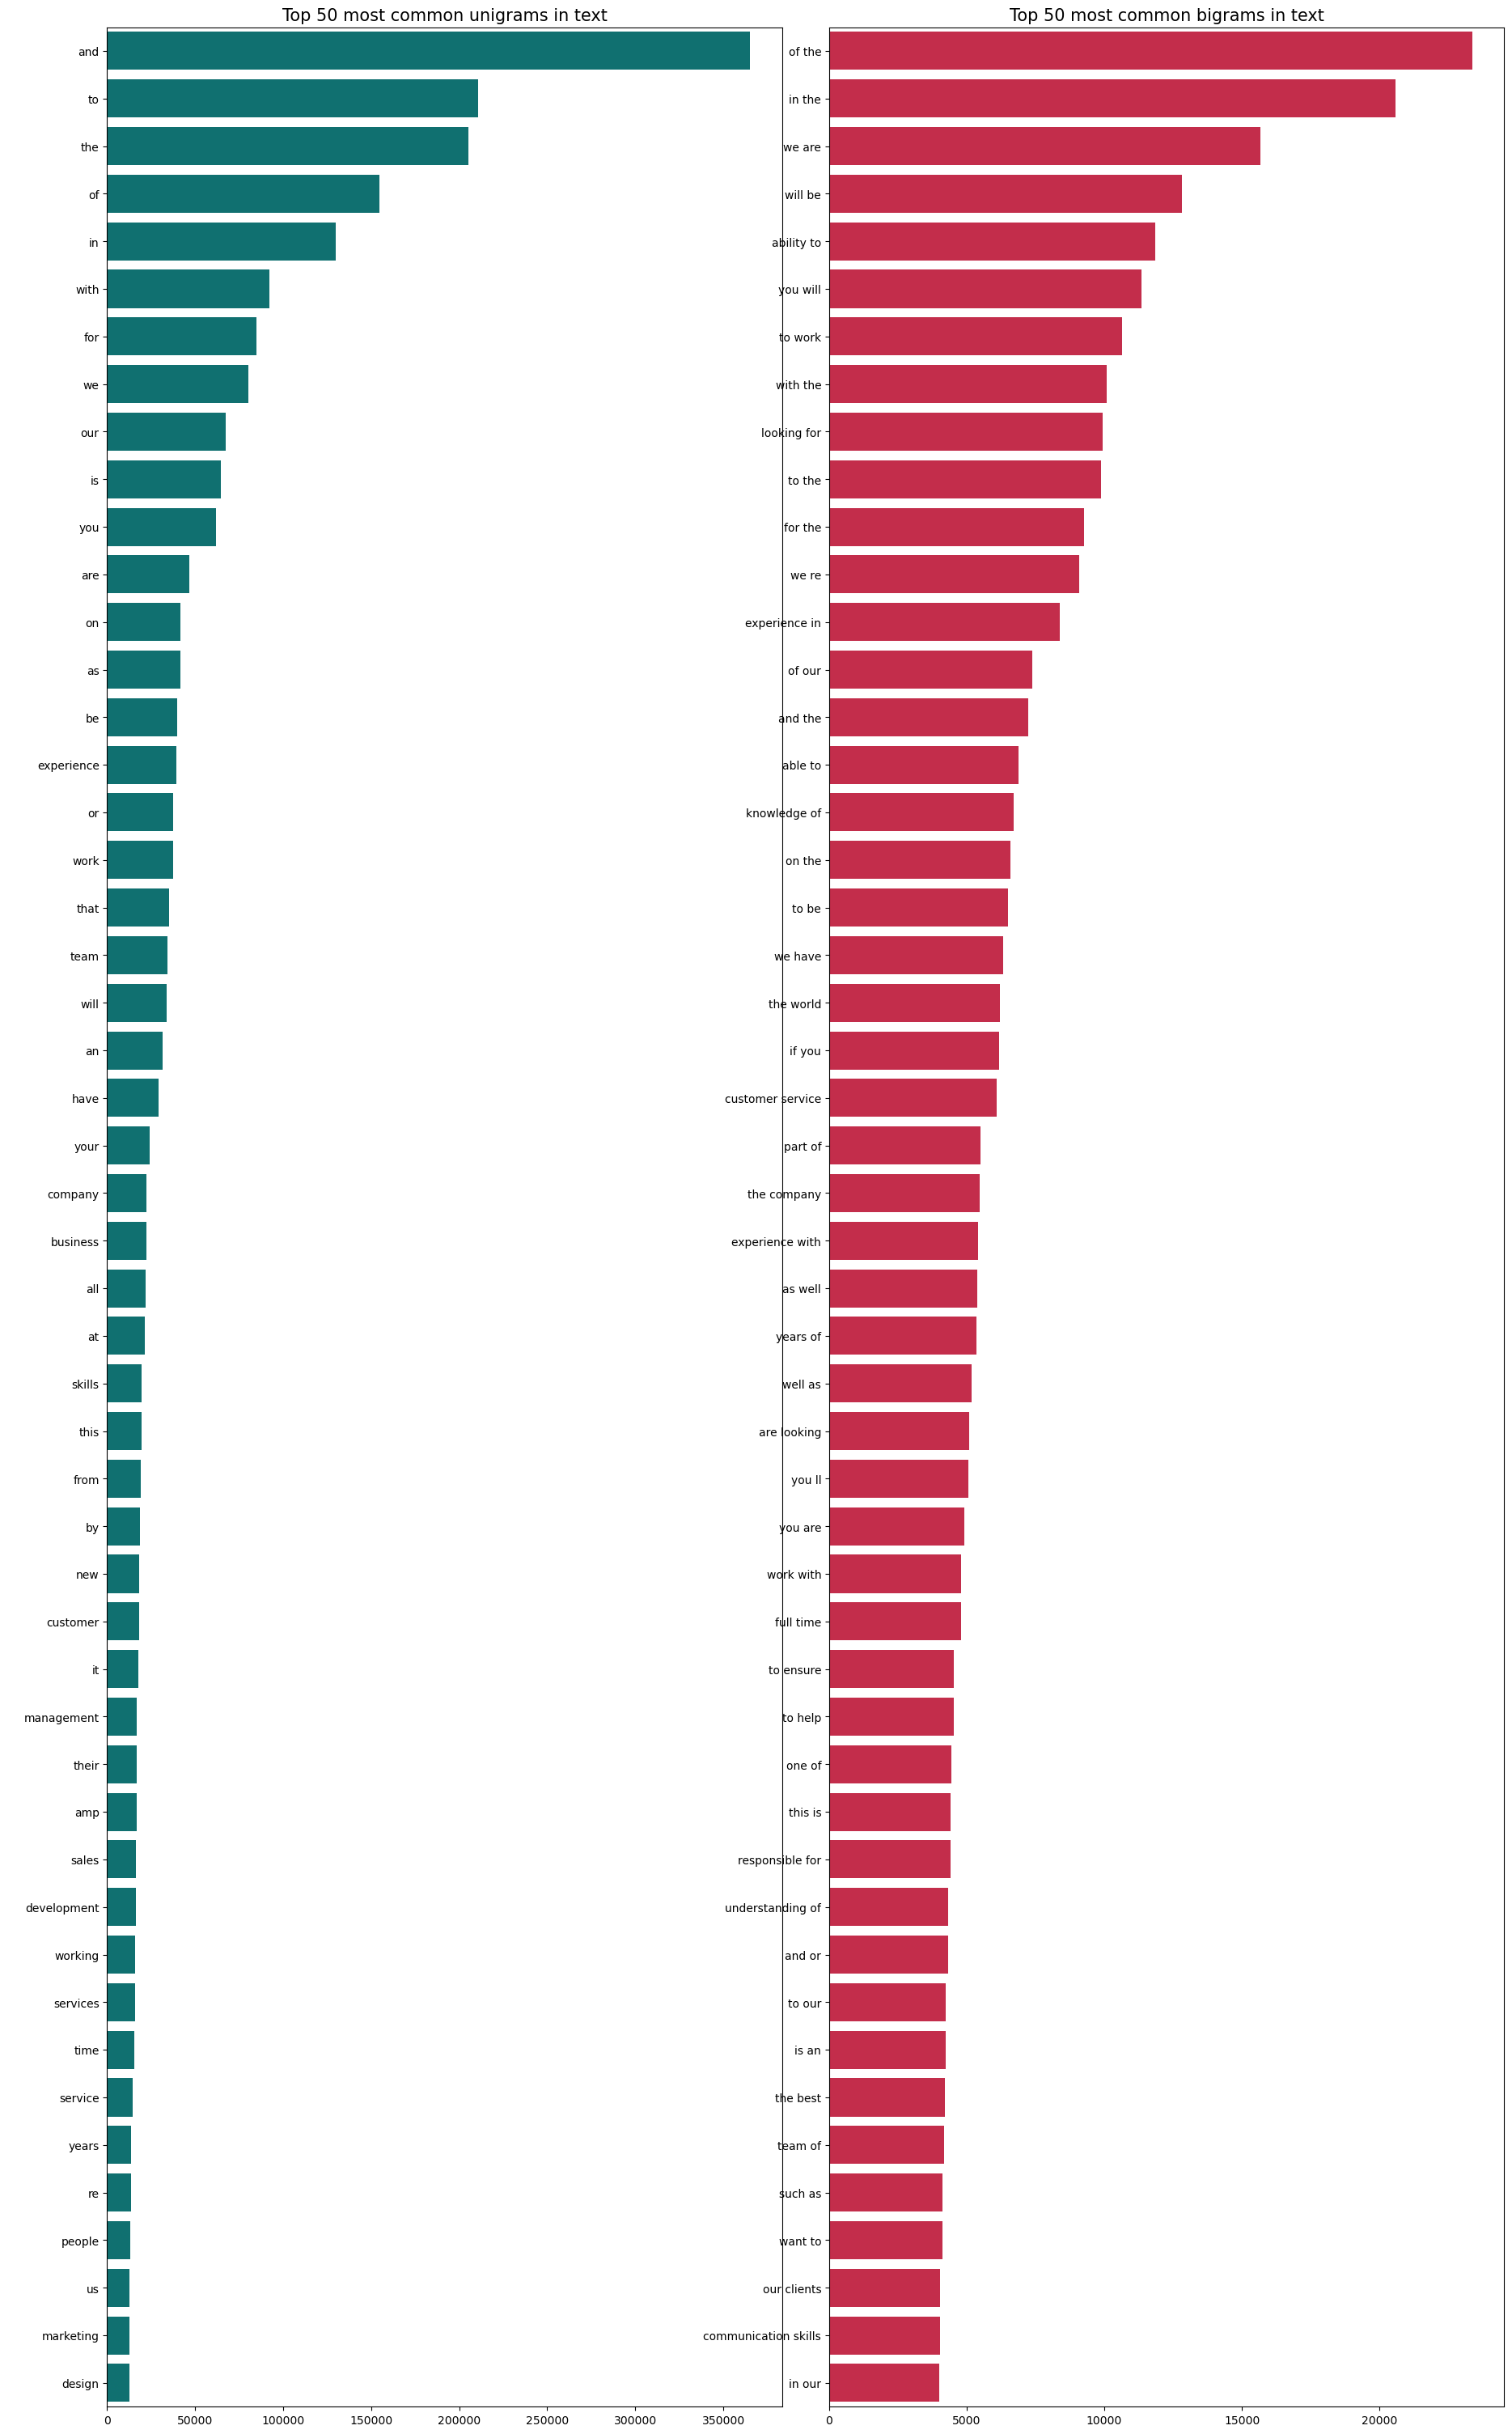

In [19]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

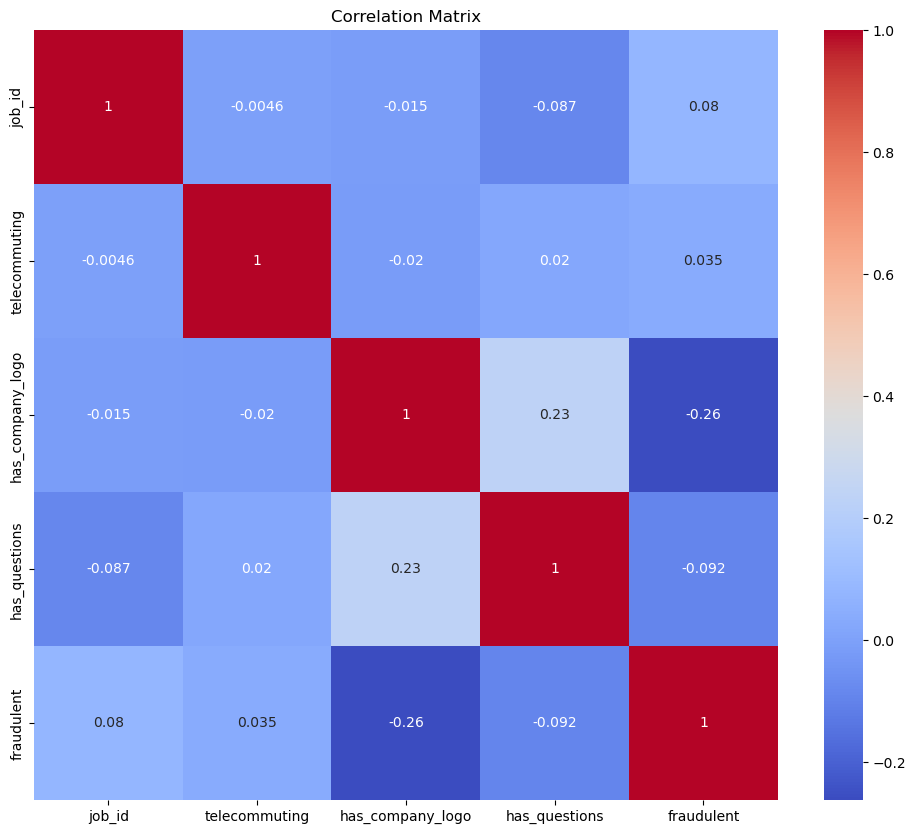

In [20]:
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, 
    remove punctuation, and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Raw string to avoid warning
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Raw string
    text = re.sub(r'<.*?>+', '', text)  # Raw string
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)  # Raw string
    text = re.sub(r'\w*\d\w*', '', text)  # Raw string
    return text

# Applying the cleaning function
text = text.apply(lambda x: clean_text(x))
text.head(3)

0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [22]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

0    [marketing, internwere, and, weve, created, a,...
1    [customer, service, cloud, video, seconds, the...
2    [commissioning, machinery, assistant, cmavalor...
dtype: object

In [23]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text = text.apply(lambda x : remove_stopwords(x))

In [24]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))
text.head(3)

CPU times: user 67 ms, sys: 2.83 ms, total: 69.9 ms
Wall time: 69.1 ms


0    marketing internwere weve created groundbreaki...
1    customer service cloud video seconds worlds cl...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [25]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = []   
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)    
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)
    lr.fit(train_X_vec, train_y)
    preds = lr.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1
0 AUC: 0.8457923049876087
Fold 2
1 AUC: 0.8517195809885532
Fold 3
2 AUC: 0.8283043353450458
Fold 4
3 AUC: 0.8720977240415205
Fold 5
4 AUC: 0.8611871313020738
AUC mean score = 0.851820
AUC std score = 0.014753


In [26]:
# spliting tthe data for glove
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.2, random_state=4, stratify=target)

In [27]:
import numpy as np

# Path to the GloVe embeddings file
glove_file_path = '/Users/mohitsalur/Documents/word_embeddings/glove.6B/glove.6B.200d.txt'

# Load the GloVe embeddings into a dictionary
embeddings_index = {}
try:
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vectors
    print('Found %s word vectors.' % len(embeddings_index))
except FileNotFoundError:
    print(f"Error: File not found at '{glove_file_path}'. Please verify the path.")

Found 400000 word vectors.


In [28]:
""" Function Creates a normalized vector for the whole sentence"""
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [29]:
# create glove features
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
xtest_glove = np.array([sent2vec(x) for x in tqdm(X_test)])

100%|█████████████████████████████████████| 3576/3576 [00:02<00:00, 1712.45it/s]


In [30]:
"""scale the data before any neural net"""
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input

# Define the model
model = Sequential()

# Add Input layer (explicit shape declaration)
model.add(Input(shape=(200,)))

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model to verify
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,101 (281.64 KB)

 Trainable params: 71,301 (278.52 KB)

 Non-trainable params: 800 (3.12 KB)

In [32]:
model.fit(xtrain_glove_scl, y=y_train, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xtest_glove_scl, y_test))


Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7092 - loss: 0.5642 - val_accuracy: 0.9650 - val_loss: 0.1397
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.9547 - loss: 0.1546 - val_accuracy: 0.9701 - val_loss: 0.1050
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.9631 - loss: 0.1151 - val_accuracy: 0.9732 - val_loss: 0.0958
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9685 - loss: 0.0995 - val_accuracy: 0.9751 - val_loss: 0.0877
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0780 - val_accuracy: 0.9746 - val_loss: 0.0903
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.9740 - loss: 0.0777 - val_accuracy: 0.9743 - val_loss: 0.0961
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.9763 - loss: 0.0707 - val_accuracy: 0.9790 - val_loss: 0.0879
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.9809 - loss: 0.0544 - val_

In [33]:
predictions = model.predict(xtest_glove_scl)
predictions = np.round(predictions).astype(int)
print('2 layer sequential neural net on GloVe Feature')
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
2 layer sequential neural net on GloVe Feature
AUC score : 0.84863


In [34]:
#Implementing BERT

In [35]:
new_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

In [36]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Raw string: avoids escape issues
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Applying the cleaning function
new_text = new_text.apply(lambda x: clean_text(x))
new_text.head(3)

0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
dtype: object

In [37]:
# Apply the cleaning function to the entire dataset
new_text_cleaned = new_text.apply(lambda x: clean_text(x))

# Assuming you want to apply it to the entire 'target' column too:
target_cleaned = target

# Check the value counts for the entire target
target_cleaned.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [38]:
# importing the tools 
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [39]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [40]:
%%time
# Tokenization
tokenized = new_text_cleaned.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True)))
tokenized.shape

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: user 45.7 s, sys: 61.1 ms, total: 45.7 s
Wall time: 45.7 s


(17880,)

In [41]:
# Padding ==> convert 1D array to 2D array
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(17880, 60)

In [42]:
# Masking ==>  ignore (mask) the padding we've added
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(17880, 60)

In [43]:
# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

last_hidden_states[0].shape

torch.Size([17880, 60, 768])

In [44]:
features = last_hidden_states[0][:,0,:].numpy()
labels = target_cleaned

In [45]:
print(features)

[[ 0.0600361  -0.0864278   0.05234081 ... -0.37005758  0.40280047
  -0.13225777]
 [-0.0575145  -0.13685808  0.17555796 ... -0.23379458  0.2694164
   0.19146906]
 [-0.02826902 -0.05046919  0.05097549 ... -0.21316147  0.19898905
   0.19785255]
 ...
 [ 0.02593137 -0.00855615 -0.10332425 ... -0.18978877  0.38207355
   0.32542232]
 [ 0.21182308 -0.04256425  0.1196022  ... -0.37073663  0.3569724
  -0.05651754]
 [ 0.1979817  -0.09458296 -0.0272286  ... -0.41856277  0.30310032
   0.2993164 ]]


In [46]:
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
17875    0
17876    0
17877    0
17878    0
17879    0
Name: fraudulent, Length: 17880, dtype: int64


In [47]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)


In [48]:
# train default para
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)


LogisticRegression()

In [49]:
predictions = lr_clf.predict(test_features)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(test_labels, predictions),5))


AUC score : 0.7875


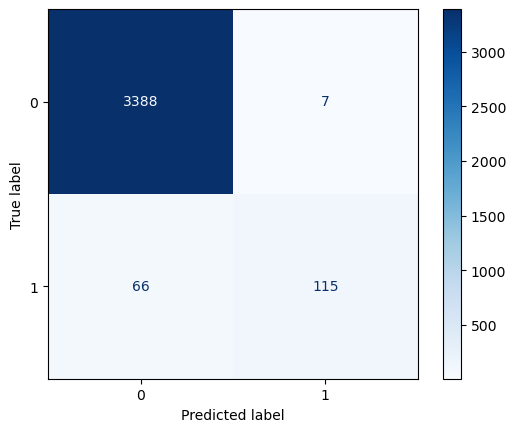

Accuracy: 97.96%
AUC Score: 0.97073
Precision (label 0): 0.98089
Recall (label 0): 0.99794
Precision (label 1): 0.94262
Recall (label 1): 0.63536


In [50]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# Assuming `features` is the extracted BERT features (last_hidden_states[0][:, 0, :].numpy())
# Assuming `labels` are your target labels (e.g., target_cleaned)

# Step 1: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 2: Create DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Step 3: Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  # For binary classification, we use AUC
    'max_depth': 6,  # You can tune this parameter
    'learning_rate': 0.1,  # You can tune this parameter
    'n_estimators': 100  # Number of boosting rounds
}

# Step 4: Train the XGBoost model
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=100)

# Step 5: Make predictions on the test set
y_pred_prob = xgb_model.predict(test_dmatrix)  # Probabilities for binary classification

# Step 6: Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Step 8: Calculate precision and recall for both 0 and 1 labels
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

# Print metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'AUC Score: {roc_auc:.5f}')
print(f'Precision (label 0): {precision[0]:.5f}')
print(f'Recall (label 0): {recall[0]:.5f}')
print(f'Precision (label 1): {precision[1]:.5f}')
print(f'Recall (label 1): {recall[1]:.5f}')

In [ ]:
import torch
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'features' is a NumPy array or a Pandas DataFrame with shape (num_nodes, feature_dim)
# 'target' is the binary labels (0 or 1) for each node

# Step 1: Prepare Node Features
node_features = torch.tensor(features, dtype=torch.float32)

# Fixing target conversion
if isinstance(target, pd.Series):  # If target is a Pandas Series
    target = target.to_numpy()
elif callable(target):  # If target is incorrectly defined as a method
    raise ValueError("target is not properly defined. Check its content.")

# Convert target to PyTorch tensor
target = torch.tensor(target, dtype=torch.long)

# Step 2: Generate Edge Index using Cosine Similarity
def generate_edge_index(features, threshold=0.8):
    """
    Generates edge_index based on cosine similarity between node features.
    Args:
        features (np.ndarray): Node features of shape (num_nodes, feature_dim)
        threshold (float): Similarity threshold to create edges.
    Returns:
        edge_index (torch.Tensor): Edge index tensor of shape [2, num_edges].
    """
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(features)
    num_nodes = similarity_matrix.shape[0]

    # Create edges where similarity > threshold
    edge_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and similarity_matrix[i, j] > threshold:
                edge_list.append([i, j])

    # Convert edge list to edge_index tensor
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

# Generate edge_index
edge_index = generate_edge_index(features, threshold=0.8)
print("Edge Index Shape:", edge_index.shape)

# Step 3: Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = pyg_nn.GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Apply first GCN layer + ReLU activation
        x = self.conv2(x, edge_index)  # Apply second GCN layer
        return x

# Step 4: Instantiate the model
input_dim = node_features.shape[1]  # Number of features per node
hidden_dim = 128  # Hidden layer size
output_dim = 2  # Output dimension for binary classification

model = GNN(input_dim, hidden_dim, output_dim)

# Step 5: Prepare the data for PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index, y=target)

# Step 6: Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 7: Training the model
model.train()
num_epochs = 100  # Number of epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    out = model(data)

    # Compute loss
    loss = criterion(out, data.y)

    # Backward pass
    loss.backward()

    # Optimize the model parameters
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Step 8: Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)

    # Get the predicted labels by taking the argmax of the output logits
    _, predicted = torch.max(out, dim=1)

    # Calculate AUC score using the predicted probabilities for class 1
    y_pred_prob = F.softmax(out, dim=1)[:, 1]  # Probabilities for class 1
    auc_score = roc_auc_score(data.y.numpy(), y_pred_prob.numpy())
    print(f'AUC score: {auc_score:.5f}')

    # Confusion Matrix and Classification Report
    print("Confusion Matrix:")
    print(confusion_matrix(data.y.numpy(), predicted.numpy()))
    print("\nClassification Report:")
    print(classification_report(data.y.numpy(), predicted.numpy()))

Edge Index Shape: torch.Size([2, 313330642])


In [ ]:
import torch
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd  # Add this import for Pandas handling

# Assuming the node features are BERT embeddings and are already in the `features` variable
# target is the binary labels for your classification task

# Step 1: Prepare your data for PyTorch Geometric
# Assuming node_features is of shape (num_nodes, feature_dim)
# edge_index is the adjacency matrix, derived earlier (shape: [2, num_edges])

# Convert node features and labels to PyTorch tensors
node_features = torch.tensor(features, dtype=torch.float32)

# Fixing target conversion
if isinstance(target, pd.Series):  # If target is a Pandas Series
    target = target.to_numpy()
elif callable(target):  # If target is incorrectly defined as a method
    raise ValueError("target is not properly defined. Check its content.")

# Ensure target is now a valid list or NumPy array
print("Target Content:", target)
print("Target Type:", type(target))

# Convert target to PyTorch tensor
target = torch.tensor(target, dtype=torch.long)  # Binary labels (0 or 1)

# Assuming edge_index is prepared (from cosine similarity or other graph structures)
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Step 2: Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = pyg_nn.GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Apply first GCN layer + ReLU activation
        x = self.conv2(x, edge_index)  # Apply second GCN layer
        return x

# Step 3: Instantiate the model
input_dim = node_features.shape[1]  # Number of features per node (BERT embeddings)
hidden_dim = 128  # Hidden layer size
output_dim = 2  # Output dimension for binary classification (fraudulent or not)

model = GNN(input_dim, hidden_dim, output_dim)

# Step 4: Prepare the data for PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index, y=target)

# Step 5: Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 6: Training the model
model.train()
num_epochs = 100  # Number of epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    out = model(data)

    # Compute loss
    loss = criterion(out, target)

    # Backward pass
    loss.backward()

    # Optimize the model parameters
    optimizer.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Step 7: Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)

    # Get the predicted labels by taking the argmax of the output logits
    _, predicted = torch.max(out, dim=1)

    # Calculate AUC score using the predicted probabilities for class 1
    y_pred_prob = F.softmax(out, dim=1)[:, 1]  # Probabilities for class 1
    auc_score = roc_auc_score(target.numpy(), y_pred_prob.numpy())
    print(f'AUC score: {auc_score:.5f}')

    # Confusion Matrix and Classification Report
    print("Confusion Matrix:")
    print(confusion_matrix(target.numpy(), predicted.numpy()))
    print("\nClassification Report:")
    print(classification_report(target.numpy(), predicted.numpy()))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # For resampling the minority class
import matplotlib.pyplot as plt

# Assuming `features` is the extracted BERT features (last_hidden_states[0][:, 0, :].numpy())
# Assuming `labels` are your target labels (e.g., target_cleaned)

# Step 1: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 2: Resample the training data using SMOTE (oversample the minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Train a Logistic Regression model with class weights (balanced) or without resampling
lr_clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # You can also use class_weight='balanced' if not using SMOTE
lr_clf.fit(X_train_resampled, y_train_resampled)  # Train on the resampled data

# Step 4: Make predictions on the test set
y_pred = lr_clf.predict(X_test)
y_pred_prob = lr_clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Step 6: Calculate precision and recall for both 0 and 1 labels
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])

# Step 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

# Print metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'AUC Score: {roc_auc:.5f}')
print(f'Precision (label 0): {precision[0]:.5f}')
print(f'Recall (label 0): {recall[0]:.5f}')
print(f'Precision (label 1): {precision[1]:.5f}')
print(f'Recall (label 1): {recall[1]:.5f}')

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # For resampling the minority class
import matplotlib.pyplot as plt

# Assuming `features` is the extracted BERT features (last_hidden_states[0][:, 0, :].numpy())
# Assuming `labels` are your target labels (e.g., target_cleaned)

# Step 1: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 2: Resample the training data using SMOTE (oversample the minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Train an XGBoost model with class weights or using scale_pos_weight for imbalanced classes
# scale_pos_weight is usually set to the ratio of negative class to positive class in imbalanced datasets
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()  # Calculate ratio of negative to positive class
xgb_clf = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=100,
    scale_pos_weight=neg_pos_ratio,  # Adjust class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the XGBoost model on the resampled data
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Step 4: Make predictions on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Step 6: Calculate precision and recall for both 0 and 1 labels
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])

# Step 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

# Print metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'AUC Score: {roc_auc:.5f}')
print(f'Precision (label 0): {precision[0]:.5f}')
print(f'Recall (label 0): {recall[0]:.5f}')
print(f'Precision (label 1): {precision[1]:.5f}')
print(f'Recall (label 1): {recall[1]:.5f}')